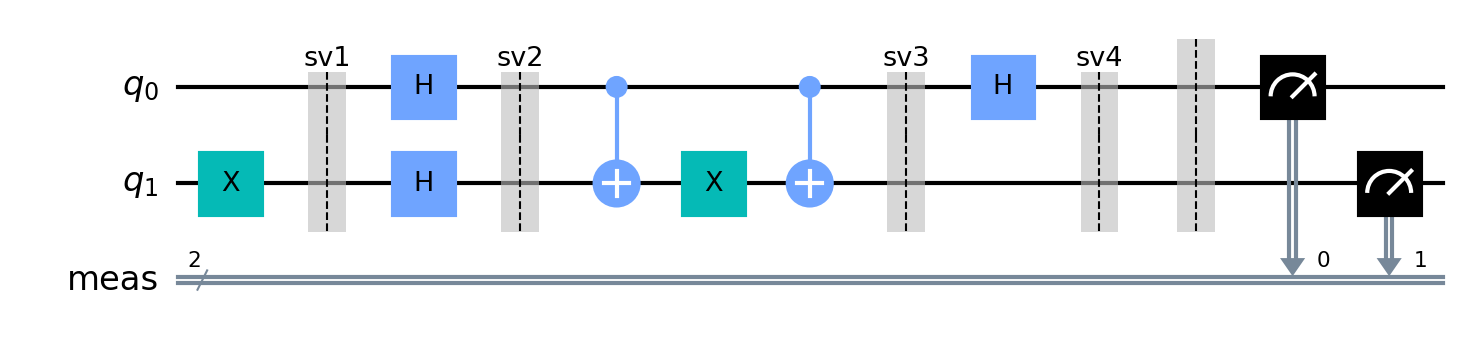

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

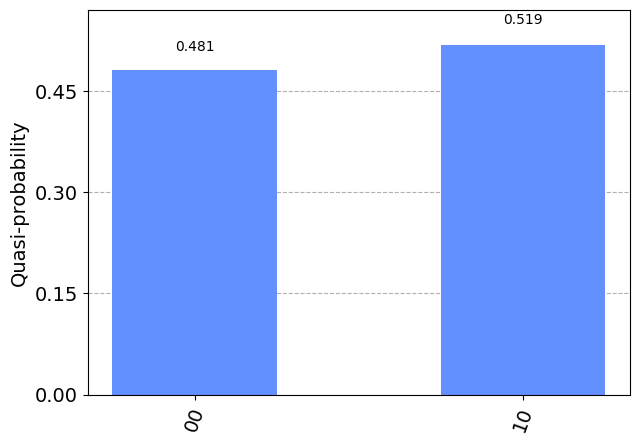

Balanced


In [1]:
# """deutsch.ipynb"""
# Cell 1 - Deutsch's Algorithm

from __future__ import annotations

import typing

import numpy as np
from IPython.core.display import Math
from qiskit import Aer, QuantumCircuit, execute  # type: ignore
from qiskit.visualization import plot_bloch_multivector  # type: ignore
from qiskit.visualization import plot_distribution  # type: ignore
from qiskit.visualization import plot_state_qsphere  # type: ignore

if typing.TYPE_CHECKING:
    from typing import Any

    from numpy.typing import NDArray


def display_array(
    a: NDArray[np.complex_], places: int = 5, column: bool = False, prefix: str = ""
) -> None:
    def strip(val: float) -> str:
        frmt: str = ":." + str(places) + "f"
        d: str = str("{v" + frmt + "}").format(v=val)
        while d[-1] == "0":
            d = d[:-1]
        if d[-1] == ".":
            d = d[:-1]
        if float(d) == 0:
            d = "0"
        return d

    m: NDArray[np.complex_] = np.copy(a)
    if len(m.shape) == 1:
        m = m[np.newaxis, :]
        if column:
            m = m.T
    prec: float = 1 / 10**places
    s: str = r"\begin{bmatrix}"
    for row in range(m.shape[0]):
        for col in range(m.shape[1]):
            v: np.complex_ = m[row, col]
            real_comp: float = float(np.real(v))
            imag_comp: float = float(np.imag(v))
            is_imag_neg: bool = imag_comp < 0
            is_real_zero: bool = bool(np.isclose(real_comp, 0, atol=prec))
            is_imag_zero: bool = bool(np.isclose(imag_comp, 0, atol=prec))
            is_imag_one: bool = bool(np.isclose(abs(imag_comp), 1, atol=prec))
            if is_real_zero:
                if is_imag_zero:
                    s += "0"
            else:
                s += strip(real_comp)
            if not is_imag_zero:
                if is_imag_one:
                    if is_imag_neg:
                        s += r"-i"
                    else:
                        if not is_real_zero:
                            s += "+"
                        s += r"i"
                else:
                    if not is_real_zero and not is_imag_neg:
                        s += " + "
                    s += strip(imag_comp) + "i"
            if col < m.shape[1] - 1:
                s += " &"
        s += r"\\"
    s += r"\end{bmatrix}"
    display(Math(prefix + s))


# Initial state of qubit 0
# where False = |0> and True = |1>
q0: bool = False

# Secret Oracle function
#f_n = 0  # BALANCED circuit (NOP)
# f_n = 1  # CONSTANT circuit (Always 0)
# f_n = 2  # CONSTANT circuit (Always 1)
f_n = 3  # BALANCED circuit (NOT)

backend: Any = Aer.get_backend("aer_simulator")
qc: Any = QuantumCircuit(2)

if q0:
    qc.x(0)
qc.x(1)
qc.save_statevector("sv1")
qc.h(0)
qc.h(1)
qc.save_statevector("sv2")

# Implement the Oracle (the secret circuit)
if f_n & 1 == 1:
    qc.cx(0, 1)
    qc.x(1)
if f_n & 2 == 2:
    qc.cx(0, 1)

qc.save_statevector("sv3")
qc.h(0)
qc.save_statevector("sv4")
qc.measure_all()

result: Any = execute(qc, backend).result()
counts: Any = result.get_counts()

sv1: Any = result.data(0)["sv1"]
sv2: Any = result.data(0)["sv2"]
sv3: Any = result.data(0)["sv3"]
sv4: Any = result.data(0)["sv4"]

display(qc.draw(output="mpl", scale=1.5))

display_array(sv1, prefix=r"\mathbf{Statevector\;1}=")
display_array(sv2, prefix=r"\mathbf{Statevector\;2}=")
display_array(sv3, prefix=r"\mathbf{Statevector\;3}=")
display_array(sv4, prefix=r"\mathbf{Statevector\;4}=")

display(plot_distribution(counts))  # type: ignore

if q0:
    if list(counts)[0][1] == "0":
        print("Constant")
    else:
        print("Balanced")
else:
    if list(counts)[0][1] == "0":
        print("Balanced")
    else:
        print("Constant")